# Self Consistent Photochemistry and Climate with `Photochem`

This notebook will take us through how to run a self-consistent radiative-convective-photochemical-equilibrium (RCPE) model with PICASO and Photochem.

For a more in depth look at the photochem code check out [Wogan et al. 2025](https://ui.adsabs.harvard.edu/abs/2025PSJ.....6..256W/abstract) (note this should also be cited along with [PICASO 4.0]() if using this code/tutorial).


Here, we will use WASP-39 b as an example. We will begin by importing several packages required for the run.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.photochem as picasochem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import constants as const
from astropy import units as u
import pandas as pd

The following cell generates a reaction network, thermodynamic file and UV spectrum required for running photochem.

In [2]:
# Generate files needed for Photochem

# Reaction and Thermodynamic files
picasochem.generate_photochem_rx_and_thermo_files(
    atoms_names=['H','He','N','O','C','S'], # Atoms to include
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml'
)

# Stellar Spectrum. Here we choose TOI-193, a sensible
# Proxy for WASP-39 b. We have to set the Teq so that the
# Spectrum is scale to the planet.
from photochem.utils import stars
wv, F = stars.muscles_spectrum(
    'TOI-193',
    outputfile='TOI-193.txt',
    Teq=1166
)

Initialize an opacity class, specifying the molecules you want to include opacities for.

In [3]:
opacity_ck = jdi.opannection(
    method='resortrebin',
    preload_gases='all'
)

Initialize a calculation, specifying WASP-39 b parameters.

In [4]:
def make_inputs(kz=1e8, filename_guess=None):

    # Start a calculation
    cl_run = jdi.inputs(calculation="planet", climate=True) # start a calculation

    # Gravity
    r_planet = (1.332*const.R_jup).to(u.cm).value
    m_planet = (0.28*const.M_jup).to(u.g).value
    cl_run.gravity(
        radius=r_planet,
        radius_unit=u.cm,
        mass=m_planet,
        mass_unit=u.g
    )

    # Effective Temp
    tint = 200 # Intrinsic Temperature of your Planet in K
    cl_run.effective_temp(tint) # input effective temperature

    # Star
    T_star = 5485 # K, star effective temperature
    logg = 4.45 # logg , cgs
    metal = 0.01 # metallicity of star
    r_star = 0.92 # solar radius
    semi_major = 0.049 # star planet distance, AU
    cl_run.star(
        opacity_ck,
        temp=T_star,
        metal=metal,
        logg=logg,
        radius=r_star,
        radius_unit=u.R_sun,
        semi_major=semi_major,
        semi_major_unit=u.AU,
        database="phoenix"
    )

    # Guess the initial P-T profile
    nlevel = 91 # number of plane-parallel levels in your code
    if filename_guess is None:
        Teq = T_star*np.sqrt(0.5*r_star*0.00465047/semi_major)
        pt = cl_run.guillot_pt(
            Teq,
            nlevel=nlevel,
            T_int=tint,
            p_bottom=3.0,
            p_top=-7
        )
        temp_guess = pt['temperature'].values
        pressure = pt['pressure'].values
    else:
        df1 = pd.read_csv("W39b_+1.0_0.3_kzz8",sep="\t")
        temp_guess = df1['temperature'].values
        pressure = df1['pressure'].values

    rcb_guess = 78
    rfacv = 0.5 # Heat-redistribution

    # Set climate inputs
    cl_run.inputs_climate(
        temp_guess=temp_guess,
        pressure=pressure,
        rcb_guess=rcb_guess,
        rfacv=rfacv
    )

    # Below, we will provide the inputs required to run photochem.
    # The key things to change are planet mass, planet radius,
    # stellar XUV flux file.
    photochem_init_args={
        'mechanism_file': "photochem_rxns.yaml",
        'thermo_file': "photochem_thermo.yaml",
        'stellar_flux_file': "TOI-193.txt",
        'P_ref': 1e6, # dynes/cm^2
        'TOA_pressure': 1e-8*1e6 #dynes/cm^2
    }
    cl_run.atmosphere(
        mh=10,
        cto_relative=0.3,
        chem_method='photochem+visscher',
        photochem_init_args=photochem_init_args
    )
    # Grab the Photochem object and adjust any settings if needed
    pc = cl_run.inputs['climate']['pc']
    pc.var.conv_longdy = 0.05 # relax convergence criteria for photochem.

    # Set the Kzz profile.
    cl_run.inputs['atmosphere']['profile']['kz'] = kz # cm^2/s

    return cl_run

cl_run = make_inputs()

Now run the model. This might take a looongg time. So please be patient.

In [5]:
out = cl_run.climate(
    opacity_ck,
    save_all_profiles=True,
    save_all_kzz=False,
    self_consistent_kzz=False,
    diseq_chem=True
)

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False


Computed quenched levels at {'CO-CH4-H2O': np.int64(52), 'CO2': np.int64(35), 'NH3-N2': np.int64(54), 'HCN': np.int64(51), 'PH3': np.int64(44)}
Running photochem


nsteps = 100  longdy = 2.2e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08


nsteps = 200  longdy = 3.0e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08


nsteps = 300  longdy = 8.4e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 2.6e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 500  longdy = 1.5e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 600  longdy = 2.3e+02  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 700  longdy = 6.9e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.5e-08


nsteps = 800  longdy = 6.0e+00  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 2.3e-08


nsteps = 900  longdy = 2.7e+02  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 3.8e-08


nsteps = 1000  longdy = 2.3e+06  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 5.3e-08


nsteps = 1100  longdy = 2.9e+01  max_dT = 8.0e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 3.6e-08


nsteps = 1200  longdy = 5.7e+03  max_dT = 8.1e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 5.6e-08


nsteps = 1300  longdy = 1.4e+05  max_dT = 8.1e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 7.4e-08


nsteps = 1400  longdy = 1.1e+05  max_dT = 8.2e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 8.8e-08


nsteps = 1500  longdy = 1.9e+00  max_dT = 8.5e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 9.4e-08


nsteps = 1600  longdy = 2.5e+00  max_dT = 8.8e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 9.6e-08


nsteps = 1700  longdy = 2.3e+00  max_dT = 8.9e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 9.7e-08


nsteps = 1800  longdy = 3.5e+00  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.0e-07


nsteps = 1900  longdy = 7.5e+02  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.0e-07


nsteps = 2000  longdy = 1.8e+02  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.5e-08


nsteps = 2100  longdy = 5.8e-01  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 8.3e-09


nsteps = 2200  longdy = 7.2e-01  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 8.3e-09


nsteps = 2300  longdy = 9.6e-01  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 8.3e-09


nsteps = 2400  longdy = 6.4e+00  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 8.3e-09


nsteps = 2500  longdy = 1.9e+00  max_dT = 1.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 8.3e-09


nsteps = 2600  longdy = 2.2e+01  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 8.9e-09


nsteps = 2700  longdy = 3.1e+00  max_dT = 4.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.9e-09


nsteps = 2800  longdy = 2.1e+00  max_dT = 5.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.9e-09


nsteps = 2900  longdy = 1.0e+00  max_dT = 5.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.9e-09


nsteps = 3000  longdy = 4.9e-01  max_dT = 5.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.9e-09


nsteps = 3100  longdy = 9.2e-02  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.3e-09


nsteps = 3200  longdy = 1.0e+00  max_dT = 1.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.3e-09


nsteps = 3300  longdy = 8.5e-02  max_dT = 1.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.3e-09


nsteps = 3391  longdy = 4.9e-02  max_dT = 1.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Iteration number  0 , min , max temp  975.4867131316165 3933.1515032863867 , flux balance  158.51792510745994
Iteration number  1 , min , max temp  800.429469893055 5001.373338709356 , flux balance  16.75029881354142


Iteration number  2 , min , max temp  749.5115428663905 4655.663896484371 , flux balance  0.4763038760385598
Iteration number  3 , min , max temp  744.6727489252805 4590.735967816623 , flux balance  0.0034717947444686537
Iteration number  4 , min , max temp  744.6069406764617 4588.3731981041155 , flux balance  1.727037212226963e-05
In t_start: Converged Solution in iterations  4
Computed quenched levels at {'CO-CH4-H2O': np.int64(53), 'CO2': np.int64(37), 'NH3-N2': np.int64(56), 'HCN': np.int64(52), 'PH3': np.int64(44)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 9.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 8.5e-01  max_dT = 8.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 1.5e+00  max_dT = 8.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 6.1e+02  max_dT = 1.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 500  longdy = 2.4e+01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 600  longdy = 2.3e+01  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 700  longdy = 6.9e+00  max_dT = 6.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08


nsteps = 786  longdy = 3.3e-02  max_dT = 6.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08


nsteps = 886  longdy = 4.4e-01  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.0e-09


nsteps = 986  longdy = 9.8e-01  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.0e-09


nsteps = 1086  longdy = 3.0e-03  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09
nsteps = 1087  longdy = 1.3e-03  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


Big iteration is  744.6069406764617 0
Iteration number  0 , min , max temp  745.5749169489219 4696.881427052109 , flux balance  42.66108596571129


Iteration number  1 , min , max temp  762.7456713900208 5199.9 , flux balance  1.9876532152264947
Iteration number  2 , min , max temp  762.3721577737911 5199.9 , flux balance  0.017155636772502907
Iteration number  3 , min , max temp  762.370112159913 5199.9 , flux balance  8.85852300745389e-05
Iteration number  4 , min , max temp  762.3701019410645 5199.9 , flux balance  4.433228532084037e-07
In t_start: Converged Solution in iterations  4
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 4.8e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 4.4e+00  max_dT = 1.2e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.3e+01  max_dT = 1.8e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 5.4e+02  max_dT = 2.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 500  longdy = 3.0e+00  max_dT = 2.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 1.3e+01  max_dT = 1.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.5e-08


nsteps = 700  longdy = 1.7e+01  max_dT = 8.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 800  longdy = 1.3e+00  max_dT = 8.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 837  longdy = 2.0e-02  max_dT = 8.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 937  longdy = 2.1e-01  max_dT = 2.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1037  longdy = 4.1e+00  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1137  longdy = 4.2e+00  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1237  longdy = 4.0e+00  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1337  longdy = 4.1e+00  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1437  longdy = 4.3e+00  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1537  longdy = 1.4e+00  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1571  longdy = 4.6e-02  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Big iteration is  762.3701019410645 1
Iteration number  0 , min , max temp  762.5708645714935 5199.9 , flux balance  9.010052820314266


Iteration number  1 , min , max temp  764.2106983048512 5199.9 , flux balance  0.14952743660281978
Iteration number  2 , min , max temp  764.2142945340595 5199.9 , flux balance  0.000780480759826938
Iteration number  3 , min , max temp  764.2143110169908 5199.9 , flux balance  3.803166918146784e-06
In t_start: Converged Solution in iterations  3
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 2.6e+00  max_dT = 1.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 1.2e+02  max_dT = 1.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 2.5e+00  max_dT = 2.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 1.4e+01  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.7e+01  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 2.0e+01  max_dT = 1.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 700  longdy = 1.3e+01  max_dT = 6.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 800  longdy = 1.0e+00  max_dT = 4.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 861  longdy = 1.9e-02  max_dT = 4.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


Big iteration is  764.2143110169908 2
Iteration number  0 , min , max temp  764.1582491015118 5199.9 , flux balance  1.8836561385952226


Iteration number  1 , min , max temp  763.862786188351 5199.9 , flux balance  0.01643617643701852
Iteration number  2 , min , max temp  763.8611440320734 5199.9 , flux balance  8.213300076085941e-05
In t_start: Converged Solution in iterations  2
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 1.2e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 1.4e+02  max_dT = 2.2e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 9.9e-01  max_dT = 2.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 400  longdy = 2.1e+01  max_dT = 1.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 2.3e+00  max_dT = 7.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 536  longdy = 4.2e-02  max_dT = 7.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 636  longdy = 2.5e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 736  longdy = 1.1e+00  max_dT = 2.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 836  longdy = 1.2e-03  max_dT = 2.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09
nsteps = 837  longdy = 9.2e-04  max_dT = 2.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Big iteration is  763.8611440320734 3
Iteration number  0 , min , max temp  763.8344471488829 5199.9 , flux balance  0.7426850665415892


Iteration number  1 , min , max temp  763.7259909650937 5199.9 , flux balance  0.004573882122882748
Iteration number  2 , min , max temp  763.7257584720907 5199.9 , flux balance  2.2248295308745584e-05
In t_start: Converged Solution in iterations  2
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.4e+02  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 1.3e+00  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.8e+01  max_dT = 1.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.2e+01  max_dT = 5.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 574  longdy = 4.4e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 674  longdy = 2.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 774  longdy = 2.5e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 874  longdy = 4.7e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09
nsteps = 879  longdy = 4.2e-02  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Profile converged before itmx


Move up two levels


Computed quenched levels at {'CO-CH4-H2O': np.int64(55), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.9e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 1.1e+02  max_dT = 1.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 9.2e-01  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.9e+01  max_dT = 1.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 7.2e+00  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 600  longdy = 1.7e-01  max_dT = 5.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 624  longdy = 3.8e-02  max_dT = 5.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 724  longdy = 5.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 824  longdy = 5.6e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 924  longdy = 6.1e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1024  longdy = 5.9e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1124  longdy = 3.6e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1224  longdy = 1.4e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1314  longdy = 4.8e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Iteration number  0 , min , max temp  763.2022053212278 5199.9 , flux balance  0.001809185284319555
Iteration number  1 , min , max temp  763.1990110542214 5199.9 , flux balance  8.662998592740322e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.3e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 1.3e+01  max_dT = 1.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 1.7e+02  max_dT = 2.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.2e+01  max_dT = 1.8e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.5e+01  max_dT = 6.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 8.5e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 604  longdy = 4.1e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 704  longdy = 4.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 804  longdy = 1.4e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 904  longdy = 3.7e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1004  longdy = 3.7e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1104  longdy = 3.9e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1204  longdy = 4.0e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1304  longdy = 4.0e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1404  longdy = 2.1e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1504  longdy = 1.5e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1604  longdy = 9.3e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1704  longdy = 1.8e-01  max_dT = 8.8e-01  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1804  longdy = 1.0e-03  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1904  longdy = 3.0e-03  max_dT = 1.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09
nsteps = 1905  longdy = 2.3e-03  max_dT = 1.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


Big iteration is  763.1990110542214 0
Iteration number  0 , min , max temp  763.913682881202 5199.9 , flux balance  0.0004426477932733899
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.0e+02  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 1.9e+00  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 400  longdy = 1.4e+01  max_dT = 1.2e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 8.3e+00  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 1.5e+01  max_dT = 7.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 700  longdy = 9.1e-01  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 724  longdy = 4.5e-02  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 824  longdy = 4.8e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 924  longdy = 5.7e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1024  longdy = 6.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1124  longdy = 3.3e+00  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1224  longdy = 4.3e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1248  longdy = 4.4e-02  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Profile converged before itmx
Move up two levels


Computed quenched levels at {'CO-CH4-H2O': np.int64(55), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.1e+02  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 1.8e+00  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 6.0e+00  max_dT = 2.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.2e+01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 7.0e+00  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 665  longdy = 3.2e-02  max_dT = 5.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 765  longdy = 3.2e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 865  longdy = 2.6e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 965  longdy = 1.3e-03  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09
nsteps = 966  longdy = 1.0e-03  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Iteration number  0 , min , max temp  763.6021101555534 4902.24485561845 , flux balance  -1.7332963071455286e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.9e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.3e+02  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 1.1e+00  max_dT = 2.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 1.7e+01  max_dT = 1.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 2.5e+00  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 531  longdy = 3.2e-02  max_dT = 5.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 631  longdy = 1.6e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 731  longdy = 4.2e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 831  longdy = 3.9e-02  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09
nsteps = 832  longdy = 4.5e-02  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Big iteration is  763.6021101555534 0
Iteration number  0 , min , max temp  763.2977259191866 4902.301939093591 , flux balance  1.9745321571675018e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.9e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 1.9e+02  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 8.7e-01  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.1e+01  max_dT = 1.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 8.2e+00  max_dT = 5.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 600  longdy = 8.8e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 618  longdy = 4.8e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 718  longdy = 4.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 818  longdy = 2.6e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 918  longdy = 3.3e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1018  longdy = 3.9e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1118  longdy = 4.0e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1206  longdy = 4.6e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(55), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 5.2e+02  max_dT = 2.2e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 3.7e+00  max_dT = 2.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 400  longdy = 1.8e+01  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 2.0e+01  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 1.9e+01  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 700  longdy = 1.8e+01  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 800  longdy = 1.7e+01  max_dT = 1.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 900  longdy = 1.4e+01  max_dT = 5.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 1000  longdy = 6.6e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 1100  longdy = 5.2e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1200  longdy = 1.4e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1300  longdy = 1.8e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1400  longdy = 2.0e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1500  longdy = 2.3e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1600  longdy = 2.5e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1700  longdy = 2.8e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1800  longdy = 2.2e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1900  longdy = 1.0e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1913  longdy = 3.9e-02  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Iteration number  0 , min , max temp  763.195255142694 4807.130421595328 , flux balance  0.0001972808937183828
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.0e+02  max_dT = 2.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 8.4e-01  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.3e+01  max_dT = 1.7e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 9.2e+00  max_dT = 7.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 1.1e+01  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 700  longdy = 9.1e-01  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 787  longdy = 4.1e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 887  longdy = 4.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 987  longdy = 3.2e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1087  longdy = 1.0e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1187  longdy = 1.7e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1224  longdy = 4.3e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Big iteration is  763.195255142694 0
Iteration number  0 , min , max temp  763.2078938566353 4807.128856052119 , flux balance  7.292850779193177e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.8e+02  max_dT = 2.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 1.4e+00  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.4e+01  max_dT = 1.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.6e+01  max_dT = 5.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 600  longdy = 5.0e-01  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 688  longdy = 4.5e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 788  longdy = 4.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 888  longdy = 1.9e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 988  longdy = 2.0e+00  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 1088  longdy = 2.8e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1128  longdy = 4.9e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Profile converged before itmx
final [0, 73, 89, 0, 0, 0]


Computed quenched levels at {'CO-CH4-H2O': np.int64(55), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.8e+02  max_dT = 2.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 1.4e+00  max_dT = 2.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 2.6e+01  max_dT = 1.5e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.1e+01  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 600  longdy = 6.2e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 606  longdy = 4.8e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 706  longdy = 3.2e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 806  longdy = 3.5e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 906  longdy = 3.6e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1006  longdy = 3.1e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1106  longdy = 3.1e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1206  longdy = 3.2e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 1297  longdy = 3.8e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Iteration number  0 , min , max temp  763.2029758384973 4807.12799435839 , flux balance  0.00021789814081935166
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 6.0e+00  max_dT = 1.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 5.7e+02  max_dT = 2.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 400  longdy = 1.0e+01  max_dT = 2.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 4.8e+00  max_dT = 9.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 600  longdy = 2.4e+00  max_dT = 5.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 637  longdy = 2.5e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 737  longdy = 3.2e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 837  longdy = 1.6e-01  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 937  longdy = 4.8e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09
nsteps = 938  longdy = 4.8e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Big iteration is  763.2029758384973 0
Iteration number  0 , min , max temp  763.2063573193138 4807.128594200814 , flux balance  -0.00011355150134482176
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(54), 'CO2': np.int64(37), 'NH3-N2': np.int64(57), 'HCN': np.int64(53), 'PH3': np.int64(45)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 4.7e+02  max_dT = 2.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 2.4e+00  max_dT = 2.4e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 400  longdy = 1.1e+01  max_dT = 1.1e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 500  longdy = 1.1e+01  max_dT = 5.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 600  longdy = 2.4e-01  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 633  longdy = 4.8e-02  max_dT = 5.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 733  longdy = 4.0e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.1e-09


nsteps = 833  longdy = 5.3e-01  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


nsteps = 933  longdy = 1.3e-03  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09
nsteps = 934  longdy = 1.1e-03  max_dT = 2.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 6.2e-09


Profile converged before itmx
YAY ! ENDING WITH CONVERGENCE


Plot the results

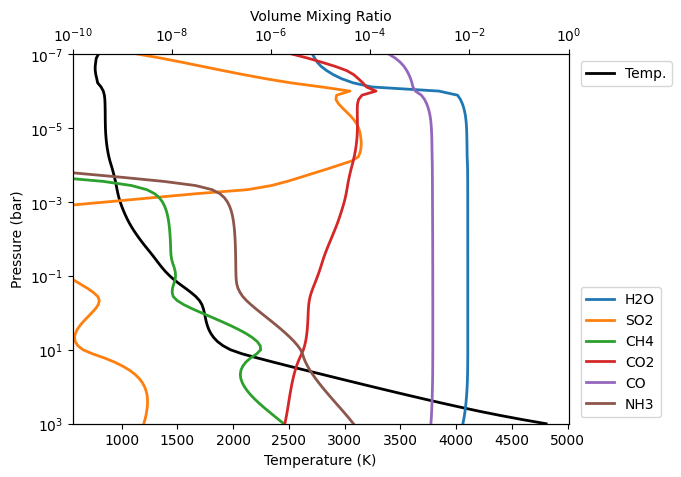

In [6]:
fig, ax = plt.subplots(1,1)

# P-T profile
ax.plot(out['ptchem_df']['temperature'], out['ptchem_df']['pressure'], c='k', lw=2, label='Temp.')
ax.set_yscale('log')
ax.set_ylim(1e3, 1e-7)
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1, bbox_to_anchor=(1.01,1.0),loc='upper left')

# Composition
ax1 = ax.twiny()
ax1.plot()
for i,sp in enumerate(['H2O','SO2','CH4','CO2','CO','NH3']):
    ax1.plot(out['ptchem_df'][sp], out['ptchem_df']['pressure'], c='C'+str(i), label=sp, lw=2)

ax1.set_xscale('log')
ax1.set_xlim(1e-10, 1)
ax1.set_xlabel('Volume Mixing Ratio')
ax1.legend(ncol=1, bbox_to_anchor=(1.01,0.0),loc='lower left')

plt.show()

Save the atmosphere to a file.

In [7]:
out['ptchem_df'].to_csv("W39b_+1.0_0.3_kzz8",sep="\t")

Now lets use this model as a guess and run a model with $K_{zz}$ = 1e11 cm$^2$/s instead.

In [8]:
# Make new inputs object with kz set to 1e11
cl_run = make_inputs(kz=1e11, filename_guess="W39b_+1.0_0.3_kzz8")

# Run climate model
out2 = cl_run.climate(
    opacity_ck,
    save_all_profiles=True,
    save_all_kzz=False,
    self_consistent_kzz=False,
    diseq_chem=True
)

# Save results
out2['ptchem_df'].to_csv("W39b_+1.0_0.3_kzz11",sep="\t")

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False


Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(53)}
Running photochem


nsteps = 100  longdy = 6.7e-01  max_dT = 4.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.9e+01  max_dT = 4.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 1.1e+01  max_dT = 5.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 2.3e+02  max_dT = 5.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 500  longdy = 5.4e+02  max_dT = 6.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 600  longdy = 2.6e+02  max_dT = 8.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 700  longdy = 2.5e+00  max_dT = 1.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.8e-08


nsteps = 790  longdy = 4.2e-02  max_dT = 2.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 2.1e-08


nsteps = 890  longdy = 3.4e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.1e-09


nsteps = 990  longdy = 6.1e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.4e-09


nsteps = 1090  longdy = 6.3e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.6e-09


nsteps = 1190  longdy = 6.2e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 9.7e-09


nsteps = 1285  longdy = 4.5e-02  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.0e-08


Iteration number  0 , min , max temp  766.7696341495327 4920.0776548723525 , flux balance  8.421285065828268
Iteration number  1 , min , max temp  814.8941936242356 5199.9 , flux balance  0.297660374713523
Iteration number  2 , min , max temp  813.5507929293042 5199.9 , flux balance  0.002230100931681027


Iteration number  3 , min , max temp  813.5372208524825 5199.9 , flux balance  1.0856939235767006e-05
Iteration number  4 , min , max temp  813.5371318535562 5199.9 , flux balance  5.2375365656743295e-08
In t_start: Converged Solution in iterations  4
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 6.3e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.4e-01  max_dT = 1.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 1.2e-02  max_dT = 1.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 301  longdy = 2.3e-02  max_dT = 1.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Big iteration is  813.5371318535562 0
Iteration number  0 , min , max temp  812.6827723700732 5199.9 , flux balance  2.0112424238202973


Iteration number  1 , min , max temp  806.7910473623203 5199.9 , flux balance  0.01888577891696237
Iteration number  2 , min , max temp  806.6596213504574 5199.9 , flux balance  9.13190736291607e-05
Iteration number  3 , min , max temp  806.6577734771465 5199.9 , flux balance  4.3040703049713023e-07
In t_start: Converged Solution in iterations  3
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 6.0e-01  max_dT = 3.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.1e-01  max_dT = 1.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 300  longdy = 2.2e-03  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 301  longdy = 5.0e-04  max_dT = 2.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Big iteration is  806.6577734771465 1
Iteration number  0 , min , max temp  805.8863351558773 5199.9 , flux balance  0.30781373581035715


Iteration number  1 , min , max temp  801.7731805757377 5199.9 , flux balance  0.002031718004273932
Iteration number  2 , min , max temp  801.6888014479504 5199.9 , flux balance  9.157844069873663e-06
In t_start: Converged Solution in iterations  2
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.6e-01  max_dT = 3.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 4.6e-01  max_dT = 3.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.7e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 385  longdy = 4.2e-02  max_dT = 2.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Profile converged before itmx
Move up two levels


Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(53)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.7e-01  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.0e-01  max_dT = 2.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 3.2e-01  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 500  longdy = 3.8e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 554  longdy = 5.0e-02  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Iteration number  0 , min , max temp  800.8308583775795 5199.9 , flux balance  -8.089764919921002e-05
Iteration number  1 , min , max temp  800.8166441113069 5199.9 , flux balance  -6.187251307731051e-07
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.3e-01  max_dT = 3.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.4e-01  max_dT = 3.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 2.7e-01  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 3.2e-01  max_dT = 2.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 488  longdy = 5.0e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Big iteration is  800.8166441113069 0
Iteration number  0 , min , max temp  801.4877450376924 5199.9 , flux balance  0.00020010988605158756
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.6e-01  max_dT = 3.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.2e-01  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 2.6e-03  max_dT = 3.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 301  longdy = 6.2e-04  max_dT = 3.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Profile converged before itmx
Move up two levels


Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(53)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.2e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 300  longdy = 1.6e-04  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 301  longdy = 2.7e-04  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Iteration number  0 , min , max temp  802.2888037518749 4902.070332765349 , flux balance  -0.00020882922309652682
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.2e-01  max_dT = 2.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.5e-01  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 385  longdy = 4.3e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Big iteration is  802.2888037518749 0
Iteration number  0 , min , max temp  802.6537417105748 4902.292350442837 , flux balance  0.00026600836597171076
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.1e-01  max_dT = 2.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.4e-01  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 3.5e-01  max_dT = 2.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 500  longdy = 3.6e-01  max_dT = 2.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 600  longdy = 3.7e-01  max_dT = 2.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 700  longdy = 3.7e-01  max_dT = 2.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 777  longdy = 4.6e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(53)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.2e-01  max_dT = 2.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.4e-01  max_dT = 2.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 378  longdy = 5.0e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Iteration number  0 , min , max temp  802.7315818883598 4807.204028577414 , flux balance  -0.00018371421960937078
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.5e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.5e-01  max_dT = 3.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 2.8e-01  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 400  longdy = 7.6e-02  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 407  longdy = 4.9e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Big iteration is  802.7315818883598 0
Iteration number  0 , min , max temp  802.7237699536007 4807.197144974496 , flux balance  0.00023377555699599553
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.4e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 300  longdy = 2.0e-04  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 301  longdy = 1.9e-03  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Profile converged before itmx
final [0, 73, 89, 0, 0, 0]


Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(53)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.8e-01  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 6.6e-02  max_dT = 2.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 306  longdy = 4.7e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Iteration number  0 , min , max temp  802.703402238569 4807.205019296953 , flux balance  -0.00021717237584267468
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 3.1e-01  max_dT = 2.8e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 3.3e-01  max_dT = 2.2e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08


nsteps = 346  longdy = 4.8e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Big iteration is  802.703402238569 0
Iteration number  0 , min , max temp  802.6840809684926 4807.197612364182 , flux balance  0.00022017861673522947
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(61), 'CO2': np.int64(46), 'NH3-N2': np.int64(67), 'HCN': np.int64(61), 'PH3': np.int64(52)}
Running photochem


nsteps = 100  longdy = 7.7e-01  max_dT = 3.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 200  longdy = 2.7e-01  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08


nsteps = 300  longdy = 2.7e-01  max_dT = 2.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


nsteps = 321  longdy = 4.7e-02  max_dT = 3.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08


Profile converged before itmx
YAY ! ENDING WITH CONVERGENCE


Compare the TP profiles between the two Kzz values

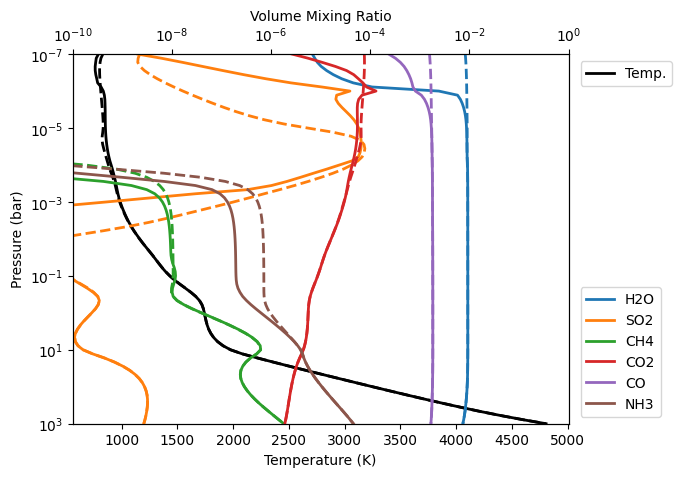

In [9]:
fig, ax = plt.subplots(1,1)

# P-T profile
ax.plot(out['ptchem_df']['temperature'], out['ptchem_df']['pressure'], c='k', lw=2, label='Temp.')
ax.plot(out2['ptchem_df']['temperature'], out2['ptchem_df']['pressure'], c='k', lw=2, ls='--')
ax.set_yscale('log')
ax.set_ylim(1e3, 1e-7)
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1, bbox_to_anchor=(1.01,1.0),loc='upper left')

# Composition
ax1 = ax.twiny()
ax1.plot()
for i,sp in enumerate(['H2O','SO2','CH4','CO2','CO','NH3']):
    ax1.plot(out['ptchem_df'][sp], out['ptchem_df']['pressure'], c='C'+str(i), label=sp, lw=2)
    ax1.plot(out2['ptchem_df'][sp], out2['ptchem_df']['pressure'], c='C'+str(i), lw=2, ls='--')

ax1.set_xscale('log')
ax1.set_xlim(1e-10, 1)
ax1.set_xlabel('Volume Mixing Ratio')
ax1.legend(ncol=1, bbox_to_anchor=(1.01,0.0),loc='lower left')

plt.show()